1. [x] load and rename variable
2. [x] remove outliers
3. derive new features
    - Split train and test sets
4. visualization
5. standardize data
6. run PCA to find the most important features
7. build and optimize model

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chisquare
from random import shuffle

from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#import module as xyz

In [186]:
## functions
def drop_outliers(ps, method=1,center="mean",variable=None):
	"""
	This function removes all outliers. These points are replaced by the mean or median
	method 1: An outlier is defined as a point lying below Q1 - 1.5IQR and above Q3 + 1.5IQR
	Q1: first quartile, Q2: median, Q3: third quartile, IQR: Q3 - Q1.
	method 2: an outlier is any point located 2.5 standard devs, far from the center(mean or median)
	Note: This doesn't work on categorical data
	input: 
		ps (pandas.dataframe or pandas.series): array of numbers to treated
		center (str): default is mean. options: mean, median
	output: pandas.series
	"""
	s = ps.describe().T
	Q1,median,Q3,mean,std = s["25%"],s["50%"],s["75%"],s['mean'], s['std']
	if method == 1:
		IQR = Q3 - Q1
		if IQR == 0:
			print "IQR == 0. ",variable, "needs a closer look"
			return ps
		else:
			ix = ps[(ps < (Q1 - 1.5 * IQR)) | (ps > (Q3 + 1.5 * IQR))].index.tolist()
			return ps
	elif method == 2:
		if center == "mean":
			ix = ps[abs(ps - mean) > 2.5 * std].index.tolist()
			ps.loc[ix] = mean
			return ps
		elif center == "median":
			ix = ps[abs(ps - median) > 2.5 * std].index.tolist()
			ps.loc[ix] = median
			return ps
		else:
			print "unknonw center"
			return ps
	else:
		print "unknonw method"
		return ps
    
def clean_data(data):
    """
    data (pandas.dataframe): raw dataframe to be cleaned
    This method will reformat IDs into integers and will rename original variables
    """
    # ID to integers
    data['ID'] = range(data.shape[0])

    # rename columns
    data.rename(columns = {'Customer Age (in months)':'Longevity - Months',
        'Churn (1 = Yes, 0 = No)':'Churn',
        'CHI Score Month 0':'Happiness Index - Current Month',
        'CHI Score 0-1':'Happiness Index - Change',
        'Support Cases Month 0':'Support Cases - Current Month',
        'Support Cases 0-1':'Support Cases - Change',
        'SP Month 0':'Support Priority - Current Month',
        'SP 0-1':'Support Priority - Change',
		'Logins 0-1':'Logins - Change',
		'Blog Articles 0-1':'Blogs - Change',
		'Views 0-1':'Views - Change',
		' Days Since Last Login 0-1':'Days Since Last Login - Change'},inplace = True)
    # drop outliers
    centers_dict = {'Support Priority - Change': 'skip', #to be transformed into categorical'Views - Change': 'mean', 
                'Longevity - Months': 'median', 
                'Blogs - Change': 'mean', 
                'Support Cases - Change': 'skip',#to be transformed into categorical. Very unbalanced 
                'Logins - Change': 'mean', 
                'Days Since Last Login - Change': 'mean', 
                'Support Priority - Current Month': 'skip', #to be transformed into categorical
                'Happiness Index - Current Month': 'median', 
                'Happiness Index - Change': 'mean', 
                'Churn': 'skip', #target variable
                'ID': 'skip', #identifier
                'Support Cases - Current Month': 'skip',#to be transformed into categorical. Very unbalanced
                'Views - Change': 'mean'}
    for k,v in centers_dict.iteritems():
        if v != 'skip':
            data[k] = drop_outliers(data[k].copy(), method=2, center=v, variable=k)
            
    # support priority variables to categorical
    data['Support Priority - Change'] = ~(data['Support Priority - Change'] == 0)*1
    data['Support Priority - Current Month'] = ~(data['Support Priority - Current Month'] == 0)*1
    data['Support Cases - Change'] = ~(data['Support Cases - Change'] == 0)*1
    data['Support Cases - Current Month'] = ~(data['Support Cases - Current Month'] == 0)*1

    return data

def biplot(score,coeff,pcax,pcay,labels=None,nm=None):
    """
    This function generate a scatter plot to visualize important features resulting from a principle component analysis
    Given dataset X, the principle components analysis generates loadings (coefficients) L and scores (new features
    in the new basis) C such that X = L*C
    inputs:
        score (matrix): components in the new basis (C)
        coeff (matrix): also called loadings (L)
        pcax (int): one of the principle components to plot
        pcay (int): another principle to plot
    """
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    if nm == None:
        nm = n
    #construct scales to constrain data between -1 and 1
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    
    #scatter data points in the new basis span by pca1 and pca2
    plt.scatter(xs*scalex,ys*scaley, marker='.',edgecolor='none')
    vectors = []
    
    #overlay transforms of original features in the new basis
    for i in range(n):
        #calculate length of vectors in new basis
        vectors.append((labels[i],np.sqrt(coeff[i,pca1]**2 + coeff[i,pca2]**2)))
        #plot arrow vectors
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='g',alpha=0.5) 
        #add labels
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='k', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='k', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    #plt.grid()
    print "Feature import (PCA)"
    print "--------------------"
    vectors = sorted(vectors,key=lambda x:x[1],reverse=True)
    pprint(vectors)
    return vectors

def standardize(ps,center="mean"):
    """
    This method standardize data to their center and a unity variance
    ps (pandas.series): data to be standardize
    center (str): central point {"mean","median"}
    """
    if center == "mean":
        return (ps - ps.mean()) / ps.std()
    if center == "median":
        return (ps - ps.median()[0]) / ps.std()
    else:
        print "unknown central point"
        return ps

def test_stat(df,ivar,tvar,equal_var=True,ddof=0):
	"""
	This function calculate statistical test to check if means are the same in groups of ivar
	split by tvar
	inputs:
		df (pandas.dataframe): data frame of interest
		ivar (str): indipendent variable
		tvar (str): target variable
	"""
	ivar_uniques = df[ivar].unique().shape[0]
	tvar_uniques = df[tvar].unique().shape[0]
	if tvar_uniques < 2:
		print "Only one sample can be generated"
		return None
	if ivar_uniques <= 10: #This the case of a categorical independant variable. We use chisquare
		ss = pd.crosstab(df[ivar],df[tvar])
		ss = (ss.T/ss.sum(axis=1)).T
		s0,s1 = ss[0].values,ss[1].values

		return chisquare(s1,s0,ddof=ddof)

	if ivar_uniques >10: #Consider using ttest
		s0 = df[ivar][df[tvar] == 0]
		s1 = df[ivar][df[tvar] == 1]
		return ttest_ind(s1,s0,equal_var=equal_var)


def modelfit(alg, xtr, ytr, performCV=True, printFeatureImportance=True, cv_folds=5,title=None):
	print title
	print "-------------------------------"
	#Fit the algorithm on the data
	alg.fit(xtr, ytr)
		
	#Predict training set:
	dtrain_predictions = alg.predict(xtr)
	dtrain_predprob = alg.predict_proba(xtr)[:,1]
	
	#Perform cross-validation:
	if performCV:
		cv_score = cross_val_score(alg, xtr, ytr, cv=cv_folds, scoring='roc_auc')
	
	#Print model report:
	#print "\nModel Report"
	print "Accuracy: %.4g" % accuracy_score(ytr.values, dtrain_predictions)
	print "AUC Score (Train): %f" % roc_auc_score(ytr, dtrain_predprob)
	
	if performCV:
		print "CV Score: Mean = %.4g | Std = %.4g | Min = %.4g | Max = %.4g" % \
		(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
		
	#Print Feature Importance:
	if printFeatureImportance:
		feat_imp = pd.Series(alg.feature_importances_, xtr.columns.tolist()).sort_values(ascending=False)
		feat_imp.plot(kind='bar', title='Feature Importances')
		plt.ylabel('Feature Importance Score')
		plt.show()
	return {'model':alg,'cv_score':cv_score}

## ========================= stratification sampling class ====================== ##   
class StratSampler():
	def __init__(self,pos,neg,posRate):
		"""
		This is a class for stratification sampling
		inputs:
			pos (list of int): list of indices of positive cases in the dataset
			neg (list of int): list of indices of negative cases in the dataset
			posRate (int): new sought positive rate. Note: posRate > initial rate
		outputs:
			sampledIds (list of int): ordered list of sampled indices
		"""
		self.pos = pos
		self.neg = neg
		self.posRate = posRate

		nchurners=len(self.pos)
		ncustomers = nchurners+len(self.neg)
		ncneeded = (100/self.posRate - 1)*nchurners
		self.ntotal = ncneeded+nchurners
		print "total number of customers:", ncustomers
		print "number of actual churners:", nchurners
		print "total number of non-churners needed to obtain {0}% of churners: {1}".format(self.posRate,ncneeded)
		print "the new sample will be made of {0}. That is {1}% of initial dataset".format(self.ntotal,100*self.ntotal/ncustomers)
		for i in range(100): #randomly reshafle the list of indices
			shuffle(self.pos)
			shuffle(self.neg)
		
		self.posId = self.pos_gen()
		self.negId = self.neg_gen()
		self.sampledIds = self.get_sampled_ids()
	def pos_gen(self): #create a chain (generator) object for positive indices
		for i in self.pos:
			yield i
	def neg_gen(self): #create a chain (generator) object for positive indices
		for i in self.neg:
			yield i
	
	def get_sampled_ids(self):
		"""
		start a loop from 0 to total size of the new sample
		"""
		seed = 123
		#initiate two lists, to save randomly picked positive and negative cases respectively
		positiveIds = []
		negativeIds = []
		i = 0
		print "==> resampling ...  ",
		while len(positiveIds)+len(negativeIds)<self.ntotal:
			# start a loop from 0 to total size of the new sampe
			# if it catches a number divisable by the sought ratio, update the list of positive cases ids
			# otherwise keep update the list of negative cases ids
			try:
				if i%int(100 / self.posRate) == 0: 
					positiveIds.append(self.posId.next())
				else:
					negativeIds.append(self.negId.next())
			except:
				print "Enter posRate higher than the initial rate"
				break
			i+=1
		print "Done sampling"
		print "positive:", len(positiveIds)
		print "negative:", len(negativeIds)
		print "final size:", len(positiveIds)+len(negativeIds)
		#return sorted list of the two list of ids combined
		return sorted(positiveIds+negativeIds)

# Load and clean data

In this section, we load the data. Next, we validate the dataset looking for missing values, invalid data types, ...

In [166]:
data = pd.read_csv('../QWE_INC/QWE Churn Data.csv')
backup = data.copy()

data = clean_data(data)
data.to_csv('QWE_Data.csv',index=False)
data = pd.read_csv('QWE_Data.csv')
print data.info()
#data.to_csv('tmp.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6347 entries, 0 to 6346
Data columns (total 13 columns):
ID                                  6347 non-null int64
Longevity - Months                  6347 non-null float64
Churn                               6347 non-null int64
Happiness Index - Current Month     6347 non-null float64
Happiness Index - Change            6347 non-null float64
Support Cases - Current Month       6347 non-null int64
Support Cases - Change              6347 non-null int64
Support Priority - Current Month    6347 non-null int64
Support Priority - Change           6347 non-null int64
Logins - Change                     6347 non-null float64
Blogs - Change                      6347 non-null float64
Views - Change                      6347 non-null float64
Days Since Last Login - Change      6347 non-null float64
dtypes: float64(7), int64(6)
memory usage: 644.7 KB
None


**Remove outliers**

I consider an outlier to be any point located at 2.5 standard deviation far from the center of data points. The center will be the mean if the distribution of the data is symmetric and the median otherwise.

**Convert some numeric data to categorical data**
Let's now convert support priority variables that we didn't clean off outliers into categorical. The initial visualization showed that about 90% of the data is zero. I opt to generate two categories 0 (zero support priority) and 1 (otherwise)

# Hypothesis
1. The probability of churning varies in different longevity
2. Happier customers are less likely to churn
3. Negative change in happiness could conduct to churning
4. Customers with high support cases could be the unhappier ones which would lead to churn events
5. Customers with high support priority are less likely to churn
6. Active customers should be less likely to churn


# Derivation of new features

**New feature -> Happiness Index - Monthly:** 

Since happiness is something that is gained progressively with a customer age and satisfaction, it is wise to have thise metric. We derive it as the ratio of Happiness Index - Current Month to Longevity.

In [167]:
data['Happiness Index - Monthly'] = data['Happiness Index - Current Month'] / data['Longevity - Months']
data['Happiness Index - Monthly'].fillna(data['Happiness Index - Monthly'].mean(),inplace=True)

**New features -> Longevity modulos **

Initial plot of churners shows peaks at longevity 6,12,18 and 24
<img src='data/longevity_churners.png'>

So, let's create new features as longevity modulo 6, 12, 18 and 24

In [168]:
for n in [6,12,18,24]:
    data['Longevity - Modulo '+str(n)] = data['Longevity - Months'].mod(n)

**New feature -> Customer Activity:** 

The activity of customers is expressed with any of number of logins, number of blogs read or number of page views. Assuming that these 3 variables contribute equally to the activity of a customer, we can standardize and combine them into one variable that we call "Customer Activity


In [169]:
data['Logins - Change'] = standardize(data['Logins - Change'].copy())
data['Blogs - Change'] = standardize(data['Blogs - Change'].copy())
data['Views - Change'] = standardize(data['Views - Change'].copy())
data['Customer Activity - Change'] = data[['Logins - Change','Blogs - Change','Views - Change']].mean(axis=1)

# Stratified Sampling

Before we move on with further analysis, let's split training and validation datasets. We shall also see that there is only 5% of positive churners. This is a case of unbalanced dataset. Therefore, we will use a stratified sampling to boost the positive rate to 20%

In [170]:
labels = ['ID','Blogs - Change', 'Customer Activity - Change', 'Days Since Last Login - Change', 
          'Happiness Index - Change', 'Happiness Index - Current Month', 'Happiness Index - Monthly', 
          'Logins - Change', 'Longevity - Modulo 12', 'Longevity - Modulo 18', 'Longevity - Modulo 24', 
          'Longevity - Modulo 6', 'Longevity - Months', 'Support Cases - Change', 'Support Cases - Current Month', 
          'Support Priority - Change', 'Support Priority - Current Month', 'Views - Change']
labels_num = sorted(['Longevity - Modulo 12', 'Longevity - Months', 'Blogs - Change', 'Days Since Last Login - Change', 
              'Longevity - Modulo 18', 'Logins - Change', 'Longevity - Modulo 24', 
              'Happiness Index - Monthly', 'Happiness Index - Current Month', 'Views - Change', 
              'Customer Activity - Change', 'Happiness Index - Change'])
labels_cat = sorted(['Support Priority - Change', 'Support Priority - Current Month', 
              'Support Cases - Change', 'Support Cases - Current Month',
              'Longevity - Modulo 6'])
labels1 = labels[1:]
target = 'Churn'

In [171]:
from sklearn.model_selection import train_test_split
_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[labels],data[target],test_size=1/4.,random_state=123)
_train_ids = _Xtrain.ID.tolist()
_valid_ids = _Xvalid.ID.tolist()

print _Ytrain.value_counts(normalize=True).round(2)

0    0.95
1    0.05
Name: Churn, dtype: float64


In [172]:
positive_ids = _Xtrain[_Ytrain == 1]['ID'].tolist()
negative_ids = _Xtrain[_Ytrain == 0]['ID'].tolist()
sampler = StratSampler(pos=positive_ids, neg=negative_ids, posRate=25)

sample = _Xtrain.loc[sampler.sampledIds]
sample[target] = _Ytrain.loc[sampler.sampledIds]
sample.to_csv('qwe_sample.csv',index=False)

total number of customers: 4760
number of actual churners: 243
total number of non-churners needed to obtain 25% of churners: 729
the new sample will be made of 972. That is 20% of initial dataset
==> resampling ...   Done sampling
positive: 243
negative: 729
final size: 972


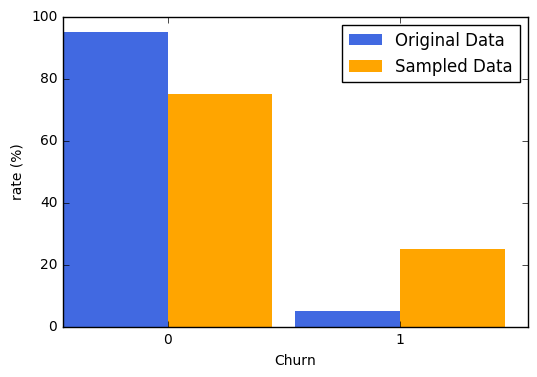

In [173]:
df1 = (100*data['Churn'].value_counts(normalize=True)).round()
df2 = (100*sample['Churn'].value_counts(normalize=True)).round()
plt.bar(df1.index,df1.values,width=0.45,color='#4169e1',edgecolor='none')
plt.bar(df2.index+0.45,df2.values,width=0.45,color='#ffa500',edgecolor='none')
plt.xticks([0.45,1.45],[0,1])
plt.xlabel("Churn")
plt.ylabel("rate (%)")
plt.legend(['Original Data','Sampled Data'])
plt.show()


# EDA & Hypothesis test

We will test our hypothesis using t-test for numerical variables and chisquare for categorical

### Customers older with age closer to 12 months are more likely to churn

In [174]:
for col in ['Longevity - Months','Longevity - Modulo 6','Longevity - Modulo 12',
            'Longevity - Modulo 18','Longevity - Modulo 24']:
    print col,test_stat(sample,col,'Churn',equal_var=False)

Longevity - Months Ttest_indResult(statistic=3.8302548917379644, pvalue=0.00014464129127790646)
Longevity - Modulo 6 Power_divergenceResult(statistic=2.2017427756745245, pvalue=0.82058419622740675)
Longevity - Modulo 12 Ttest_indResult(statistic=-3.2829492381357102, pvalue=0.0011138946381844287)
Longevity - Modulo 18 Ttest_indResult(statistic=6.1003414310799586, pvalue=2.3546784837938265e-09)
Longevity - Modulo 24 Ttest_indResult(statistic=4.1885460605714107, pvalue=3.3402362096495877e-05)


<img src="data/longevity-barplot.png">
<img src="data/longevity-boxplot.png">
The statistical hypothesis test tell us that there is a significant difference between averages of longetivity between groups of churners and non-churners with a 95% level of confidence. Customers older than 12 months are more likely to churn.

Similarly, we find the same significant difference in averages of longetivity derived varaibles, that is longetivity modulo 12, 18 and 24.

<img src="data/longevity12-boxplot.png">
<img src="data/longevity18-boxplot.png">
<img src="data/longevity24-boxplot.png">


### Happier customers are less likely to churn

In [175]:
for col in ['Happiness Index - Current Month', 
            'Happiness Index - Change', 'Happiness Index - Monthly']:
    print col,":", test_stat(sample,col,'Churn',True,0)

Happiness Index - Current Month : Ttest_indResult(statistic=-4.6645277085783841, pvalue=3.5266494458910375e-06)
Happiness Index - Change : Ttest_indResult(statistic=-0.71792256260184451, pvalue=0.47297790127340766)
Happiness Index - Monthly : Ttest_indResult(statistic=-4.7118710629834624, pvalue=2.8128415335979754e-06)


<img src="data/happinessIndex_CM-boxplot.png">
<img src="data/happinessIndex_Change-boxplot.png">
<img src="data/happinessIndex_Monthly-boxplot.png">

Customers with higher current happiness index are less and less likely to churn. The t-test result in a pvalue smaller than 0.05 indicating that we have enough evidence to say that the average happiness index of non churners is higher than the one for churners. Similarly, we find same behaviour for change in happiness Index

### Support Cases


In [176]:
for col in ['Support Cases - Change','Support Cases - Current Month']:
    print col,":", test_stat(sample,col,'Churn',True,0)
#print 'Support Cases - Change',xyz.test_stat(sample,'Support Cases - Change','Churn',False,0)
#print 'Support Cases - Current Month',xyz.test_stat(sample,'Support Cases - Current Month','Churn',False,0)
#print 'Support Cases - Current Month_Cat',xyz.test_stat(sample,'Support Cases - Current Month_Cat','Churn',False,0)

Support Cases - Change : Power_divergenceResult(statistic=0.7259048470673507, pvalue=0.39421381614910067)
Support Cases - Current Month : Power_divergenceResult(statistic=0.79193214351215857, pvalue=0.37351652647076639)


With p-values greates than 0.05, our tests fail to show that there is enough statistical evidence that can imply that the averages of support cases variables are different in groups of churners and non-churners

### Support Priority

There is not enough statistical evidence that there is difference in average of support priority in groups of churners versus non-churners

In [177]:
for col in ['Support Priority - Change','Support Priority - Current Month']:
    print col,":", test_stat(sample,col,'Churn',True,0)
#print 'Support Priority - Current Month',xyz.test_stat(sample,'Support Priority - Current Month','Churn',False,0)
#print 'Support Priority - Change',xyz.test_stat(sample,'Support Priority - Change','Churn',False,0)
#print 'Support Priority - Change_Cat',xyz.test_stat(sample,'Support Priority - Change_Cat','Churn',False,0)

Support Priority - Change : Power_divergenceResult(statistic=0.7012113118307628, pvalue=0.40237697503559955)
Support Priority - Current Month : Power_divergenceResult(statistic=0.80101946935493251, pvalue=0.37078873964876513)


With p-values greates than 0.05, our tests fail to show that there is enough statistical evidence that can imply that the averages of support priorities variables are different in groups of churners and non-churners

### Customer Activiy


In [178]:
print 'Customer Activity - Change',test_stat(sample,'Customer Activity - Change','Churn',False,0)
print 'Logins - Change',test_stat(sample,'Logins - Change','Churn',False,0)
print 'Blogs - Change',test_stat(sample,'Blogs - Change','Churn',False,0)
print 'Views - Change',test_stat(sample,'Views - Change','Churn',False,0)

Customer Activity - Change Ttest_indResult(statistic=-2.4300239089401656, pvalue=0.01551325472905804)
Logins - Change Ttest_indResult(statistic=-3.0996459314383498, pvalue=0.0020541787683100586)
Blogs - Change Ttest_indResult(statistic=-0.82405196927452029, pvalue=0.410347433470173)
Views - Change Ttest_indResult(statistic=-0.72079743591627177, pvalue=0.47148657969004593)


<img src="imgs/CustomerActivity-Boxplot.png">

### Days Since Last Login
There is a significant difference in average of change in days since last login among groups of churners versus non-churners

In [179]:
print 'Days Since Last Login - Change',test_stat(sample,'Days Since Last Login - Change','Churn',False,0)

Days Since Last Login - Change Ttest_indResult(statistic=4.002521615299484, pvalue=7.8172961468818823e-05)


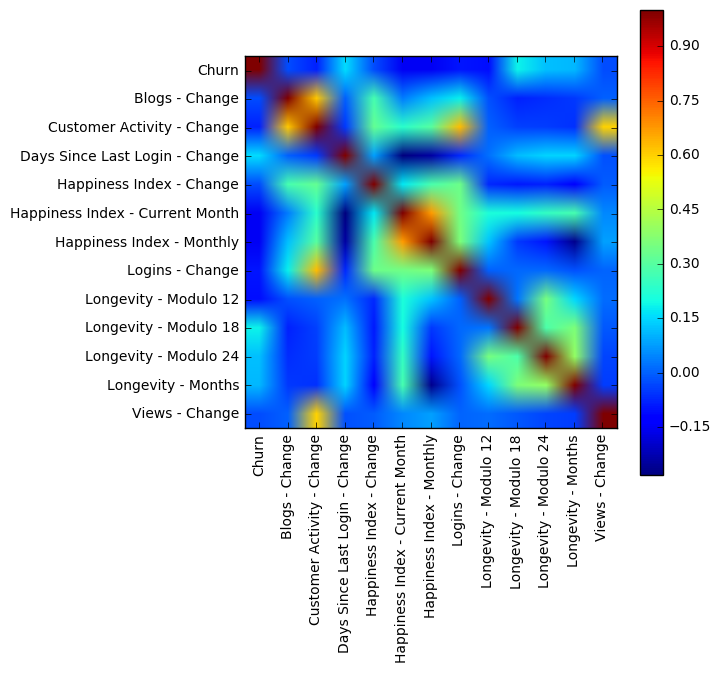

In [180]:
plt.figure(figsize=(6,6))
plt.imshow(sample[[target]+labels_num].corr().values)
plt.xticks(range(len(labels_num)+1),[target]+labels_num,rotation=90)
plt.yticks(range(len(labels_num)+1),[target]+labels_num,rotation=0)
plt.colorbar()
plt.show()

### PCA
https://github.com/teddyroland/python-biplot/blob/master/biplot.py

If X is the dataset, we use PCA to learn loadings L and a set of components C such that X = L C. I will start fitting the whole dataset and extract the number of useful components. Next, the data will be fitted again using the right number.

In this section, we will also take advantage of loadings and scores (or components) to learn the features that explain most of our churn dataset

number of useful components: 10
Feature import (PCA)
--------------------
[('Days Since Last Login - Change', 0.5464481297437116),
 ('Logins - Change', 0.47654347080858189),
 ('Customer Activity - Change', 0.4399215105422401),
 ('Longevity - Modulo 18', 0.38286044637860861),
 ('Longevity - Modulo 24', 0.36303044317823968),
 ('Happiness Index - Current Month', 0.30295534646114292),
 ('Longevity - Modulo 12', 0.28635525151807273),
 ('Blogs - Change', 0.26339530565058078),
 ('Happiness Index - Monthly', 0.22296519049976746),
 ('Happiness Index - Change', 0.031421757077930719)]


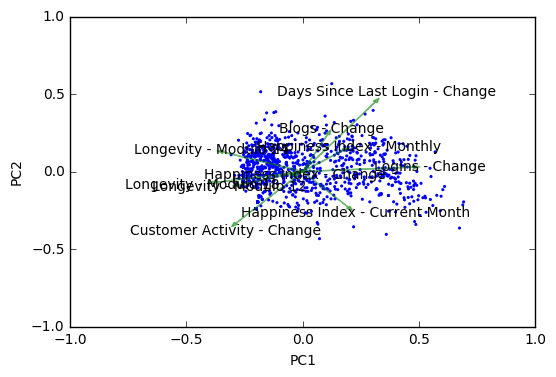

In [188]:


pca = PCA()
pca.fit(standardize(sample[labels1]))
explained_var = pca.explained_variance_
n_comp = len(filter(lambda x:x>0.6, explained_var))
print "number of useful components:",n_comp

pca = PCA(n_components=n_comp)
pca.fit(standardize(sample[labels1]))

loadings = pca.components_
scores = pca.transform(standardize(sample[labels1]))

vects = biplot(scores,loadings,1,2,labels=labels1)
plt.show()

labels_pca = map(lambda x:x[0],vects)

# Modeling


After observing so many variables whose averages are significantly different in the two groups of churners and non-churners, logistic regression would serve as a good candidate for model training.

We are going to train the basic model logistic regression with a regularization term C=1 and where our **numerical variables** (opposite to categorical variables) will be used as input and the churn variable will be used as the target. We will use 5 fold cross-validation to reduce possible overfitting. 

In [189]:
lr1 = modelfit(LogisticRegression(C=1.),sample[labels_pca],sample[target],printFeatureImportance=False,title='BasicLogisticRegression')

BasicLogisticRegression
-------------------------------
Accuracy: 0.7665
AUC Score (Train): 0.695406
CV Score: Mean = 0.6076 | Std = 0.1357 | Min = 0.3542 | Max = 0.7559


The initial model has a mean AUC of 0.6375 and standard deviation of 0.0942. We are now going to proceed with a grid search to optimize the regularization term. The best C would return higher mean  AUC score.

In [190]:
Cs = 10**np.arange(-4.,4)
for c in Cs:
    modelfit(LogisticRegression(C=1.),sample[labels_pca],sample[target],printFeatureImportance=False,title='C:'+str(c))
#c=100
#lr1 = modelfit(LogisticRegression(C=c),Xvalid[labels1],Yvalid['Churn'],printFeatureImportance=False,title=str(c))
#res = evaluateModel(lr1['model'],sample[Xtrain.columns],sample.Churn,sample[Xtrain.columns],sample.Churn,title='Best LR',retrain=False)

C:0.0001
-------------------------------
Accuracy: 0.7665
AUC Score (Train): 0.695400
CV Score: Mean = 0.6077 | Std = 0.1357 | Min = 0.3542 | Max = 0.7559
C:0.001
-------------------------------
Accuracy: 0.7665
AUC Score (Train): 0.695406
CV Score: Mean = 0.6076 | Std = 0.1356 | Min = 0.3542 | Max = 0.7558
C:0.01
-------------------------------
Accuracy: 0.7665
AUC Score (Train): 0.695400
CV Score: Mean = 0.6077 | Std = 0.1357 | Min = 0.3542 | Max = 0.7559
C:0.1
-------------------------------
Accuracy: 0.7665
AUC Score (Train): 0.695400
CV Score: Mean = 0.6076 | Std = 0.1357 | Min = 0.3542 | Max = 0.7559
C:1.0
-------------------------------
Accuracy: 0.7665
AUC Score (Train): 0.695406
CV Score: Mean = 0.6076 | Std = 0.1357 | Min = 0.3542 | Max = 0.7559
C:10.0
-------------------------------
Accuracy: 0.7665
AUC Score (Train): 0.695406
CV Score: Mean = 0.6077 | Std = 0.1357 | Min = 0.3542 | Max = 0.7559
C:100.0
-------------------------------
Accuracy: 0.7665
AUC Score (Train): 0.695

**For final model, we choose the regularization factor C = 1**

In [191]:
c = 1
lrf = modelfit(LogisticRegression(C=c),sample[labels_pca],sample[target],printFeatureImportance=False,title='C:'+str(c))

C:1
-------------------------------
Accuracy: 0.7665
AUC Score (Train): 0.695406
CV Score: Mean = 0.6076 | Std = 0.1356 | Min = 0.3542 | Max = 0.7558


## 3. Model evaluation

In [193]:
model = lrf['model']
preds = model.predict(_Xvalid[labels_pca])
print "auc score:\n\t", roc_auc_score(_Yvalid,preds)
print "confusion matrix:\n", tabulate.tabulate(pd.DataFrame(confusion_matrix(_Yvalid,preds)),headers=[0,1])

auc score:
	0.596242534837
confusion matrix:
       0    1
--  ----  ---
 0  1458   49
 1    62   18


# Recommendations

### Temptative Financial Model: How can the company invest in promotion to retain potential churners?

Assume the expense to adopt one customer x1 and teh the monthly revenue collected from each member r1 are known. Here, we are trying to estimate the money to invest in promotion to keep a predicted churner, x2.


Since we also know that the average longetivity is 12.6 $ months.

We can now optimize potential losses due to false predictions.

Loss due to false negative consists in the difference between the money collected from the customer and adoption expense

$FN_{Loss}= 12.6*r_1 - x_1$

Loss due to false positive consists in the money invested in promotion per potential churner

$FP_{Loss} = x_2$

For profit, the promotion money should decided as

$x_2*49 < (x_1 - 12.6*r_1)*62$

In [202]:
def x2(x1,r1):
    return -(x1 - 12.6*r1)*(62)/float(49)

x2(100,20)

192.3265306122449

- Important features (refer to PCA results and EDA)
- more data needed (need to generate a plot of auc as function of positive rate)

# Appendix